<a href="https://colab.research.google.com/github/StrelecTanya/scRNA-Seq_project/blob/main/full_data_lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Предобработка данных

In [ ]:
!pip install scanpy[leiden] harmonypy symphonypy bbknn

Загружаем датасет - scRNA-Seq легочной ткани, отобранные от 2х новорожденных девочек

In [ ]:
!wget https://datasets.cellxgene.cziscience.com/f7be56a5-55fc-4beb-8d5d-ffec21c11906.h5ad -O dataset.h5ad

Импортируем все необходимые библиотеки для обработки данных

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanpy as sc
import scanpy.external as sce

In [4]:
adata = sc.read_h5ad("dataset.h5ad")

В готовом файле, в adata.X уже предобработанные данные (судя по всему все шаги до шкалирования и отбора HVG). Для более адекватного результата буду работать с сырыми данными и сама их предобработаю.

In [5]:
# Создание нового объекта adata_raw с сырыми данными
adata_raw = sc.AnnData(adata.raw.X, obs=adata.obs, var=adata.raw.var)

In [6]:
adata_raw.var["mt"] = adata_raw.var.feature_name.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_raw,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)

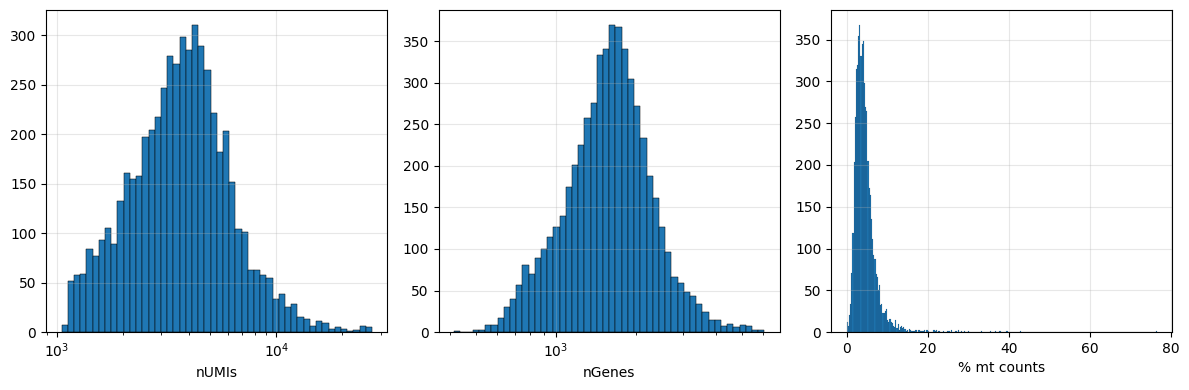

In [7]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

sns.histplot(adata_raw.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_raw.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_raw.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

fig.tight_layout()

In [8]:
adata_raw = adata_raw[adata_raw.obs.n_genes_by_counts >= 700]

In [9]:
sc.pp.scrublet(adata_raw, batch_key="donor_id")

In [11]:
adata_raw = adata_raw[adata_raw.obs.doublet_score <= 0.2].copy()

sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

In [12]:
sc.pp.highly_variable_genes(adata_raw, batch_key="donor_id", n_top_genes=3000)

adata_raw.raw = adata_raw
adata = adata_raw[:, adata_raw.var.highly_variable]

In [13]:
#Теперь можем стандартизировать данные и сделать PCA
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata, n_comps=30)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Теперь можем отобрать батчи

<ipython-input-14-693fd862f1ec>:17: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_nocorr, resolution=0.1)


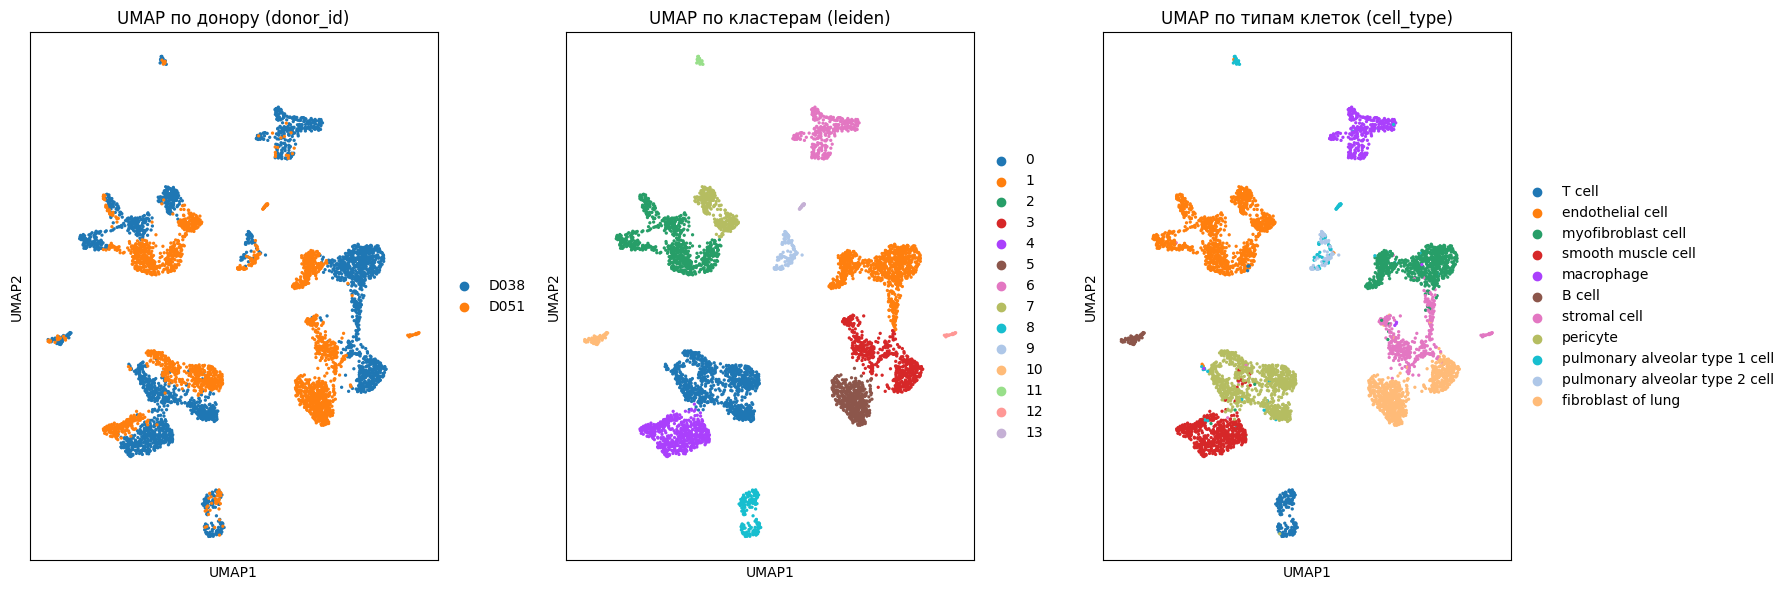

In [14]:
#Визуализация без батч-коррекции
# Создаем копию данных
adata_nocorr = adata.copy()

# Предобработка данных
sc.pp.neighbors(adata_nocorr)
sc.tl.umap(adata_nocorr)

# Создание подграфиков (subplots)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Увеличиваем ширину фигуры

# Первый график - окрашивание по донору (donor_id)
sc.pl.umap(adata_nocorr, color='donor_id', ax=axes[0], show=False)
axes[0].set_title("UMAP по донору (donor_id)")

# Кластеризация и второй график - окрашивание по кластерам (leiden)
sc.tl.leiden(adata_nocorr, resolution=0.1)
sc.pl.umap(adata_nocorr, color="leiden", ax=axes[1], show=False)
axes[1].set_title("UMAP по кластерам (leiden)")

# Третий график - окрашивание по типам клеток (cell_type)
sc.pl.umap(adata_nocorr, color="cell_type", ax=axes[2], show=False)
axes[2].set_title("UMAP по типам клеток (cell_type)")

# Отображение графиков
plt.tight_layout()
plt.show()
